# Implementation of "A Neural Algorithm of Style"
This is an implementation in Python and [Caffe](http://caffe.berkeleyvision.org/) of a recent paper, *A Neural Algorithm of Artistic Style* by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge, that became very well-known and has some online implementations such as <https://deepart.io/>.  The paper is available at <http://arxiv.org/abs/1508.06576> and I refer to many of its equations in this Python notebook. This took inspiration and methods from some of the numerous implementations already available of this:

 - <https://github.com/jcjohnson/neural-style>
 - <https://github.com/andersbll/neural_artistic_style>
 - <https://github.com/fzliu/style-transfer>
 - <https://github.com/woodrush/neural-art-tf>

## Setup
Standard imports are below. While I use `skimage`, the familiar `cv2` routines for image loading would likely also work.

`caffe` is via <http://caffe.berkeleyvision.org/> and this, as far as I know, has bindings only for Python 2.x.

In [1]:
import caffe
import numpy
import skimage
import scipy.optimize

The below is only for the sake of displaying images in this notebook. If running this code standalone, it can be omitted.

In [2]:
import IPython.display

Now, initialize caffe to make use of GPU 0.
(If you have no GPU, or no CUDA support in Caffe, replace the below with `caffe.set_mode_cpu()` and expect things to take much longer.)

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

## Loading Pre-trained Neural Network
We require a pre-trained neural network for this. Many will work here, but here I am using the Caffenet model from <http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel> and the network description from <https://github.com/fzliu/style-transfer/blob/master/models/caffenet/deploy.prototxt>. It is a small enough model that it fits on some more modest GPUs. The below loads this model into Caffe:

In [4]:
net = caffe.Net("caffenet/deploy.prototxt",
                "caffenet/bvlc_reference_caffenet.caffemodel",
                caffe.TEST)

See <https://github.com/fzliu/style-transfer/tree/master/models> for some models that are already in the correct format. Another interesting one, already in Caffe's format, is at <http://illustration2vec.net/>.

We can inspect the neural network's structure too. <http://caffe.berkeleyvision.org/tutorial/net_layer_blob.html> contains a good explanation of what Net, Layer, and Blob mean, to give this some context.  <http://caffe.berkeleyvision.org/tutorial/layers.html> explains the different layer types shown below (and others). However, understanding this is not crucial to what else we do.

In [19]:
for i,layer in enumerate(net.layers):
    print("%d: %s, %d blobs" % (i, layer.type, len(layer.blobs)))
    for j,blob in enumerate(layer.blobs):
        print("\tBlob %d: %d x %d channels of %dx%d" %
              (j, blob.num, blob.channels, blob.width, blob.height))

0: Input, 0 blobs
1: Convolution, 2 blobs
	Blob 0: 96 x 3 channels of 11x11
	Blob 1: 96 x 1 channels of 1x1
2: ReLU, 0 blobs
3: Pooling, 0 blobs
4: LRN, 0 blobs
5: Convolution, 2 blobs
	Blob 0: 256 x 48 channels of 5x5
	Blob 1: 256 x 1 channels of 1x1
6: ReLU, 0 blobs
7: Pooling, 0 blobs
8: LRN, 0 blobs
9: Convolution, 2 blobs
	Blob 0: 384 x 256 channels of 3x3
	Blob 1: 384 x 1 channels of 1x1
10: ReLU, 0 blobs
11: Convolution, 2 blobs
	Blob 0: 384 x 192 channels of 3x3
	Blob 1: 384 x 1 channels of 1x1
12: ReLU, 0 blobs
13: Convolution, 2 blobs
	Blob 0: 256 x 192 channels of 3x3
	Blob 1: 256 x 1 channels of 1x1
14: ReLU, 0 blobs
15: Pooling, 0 blobs


The Blobs are the actual part we're interested in, particularly, those corresponding to convolution layers, and we can inspect some of them below:

In [18]:
for name in net.blobs.keys():
    blob = net.blobs[name]
    print("Blob '%s': %d x %d channels of %dx%d" %
          (name, blob.num, blob.channels, blob.width, blob.height))

Blob 'data': 10 x 3 channels of 227x227
Blob 'conv1': 10 x 96 channels of 55x55
Blob 'pool1': 10 x 96 channels of 27x27
Blob 'norm1': 10 x 96 channels of 27x27
Blob 'conv2': 10 x 256 channels of 27x27
Blob 'pool2': 10 x 256 channels of 13x13
Blob 'norm2': 10 x 256 channels of 13x13
Blob 'conv3': 10 x 384 channels of 13x13
Blob 'conv4': 10 x 384 channels of 13x13
Blob 'conv5': 10 x 256 channels of 13x13
Blob 'pool5': 10 x 256 channels of 6x6


We need to pick certain layers that represent "content", and certain layers that represent "style".  The paper gives some more information on this, but these layers are also specific to the model and involve some level of trial-and-error. Lower layers capture more detailed pixel information, while higher layers capture a higher-level representation.

In [14]:
style_layers = ["conv1", "conv2", "conv3", "conv4", "conv5"]
content_layers = ["conv4"]
layers = [l for l in net.blobs if l in content_layers or l in style_layers]

## Input Images
Next, we need a content image and a style image - an image which contributes content we're trying to match, and an image which contributes style we're trying to match.  (Actually, there can be multiple content images and multiple style images, but that's another matter.)

Let's try this as a style image:

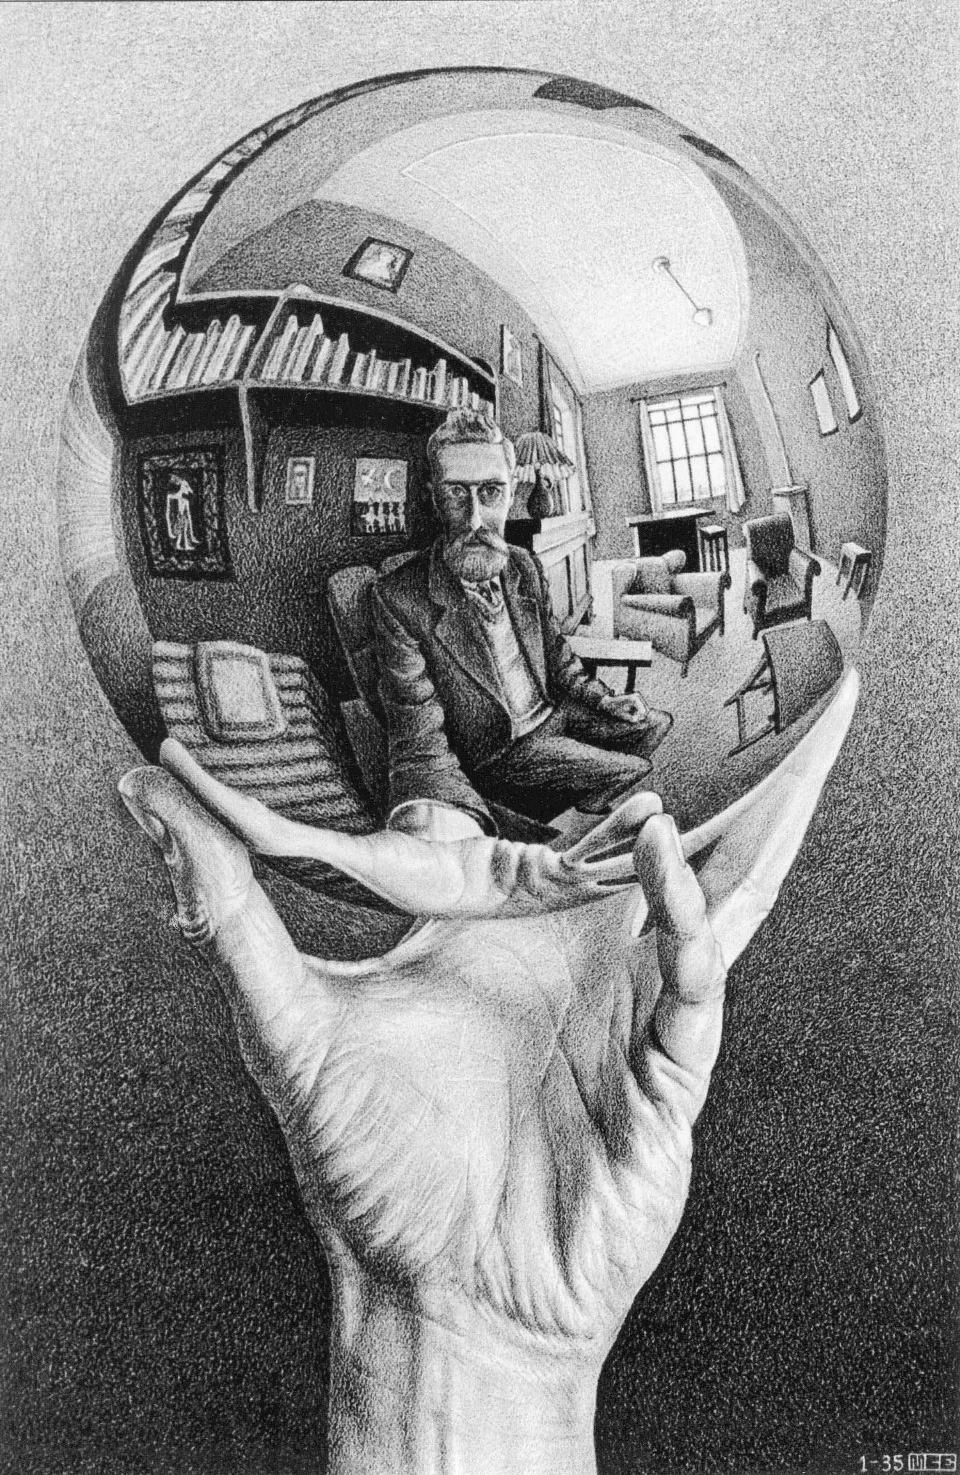

In [20]:
IPython.display.Image(filename = "./escher_sphere.jpg")

and this as a content image:

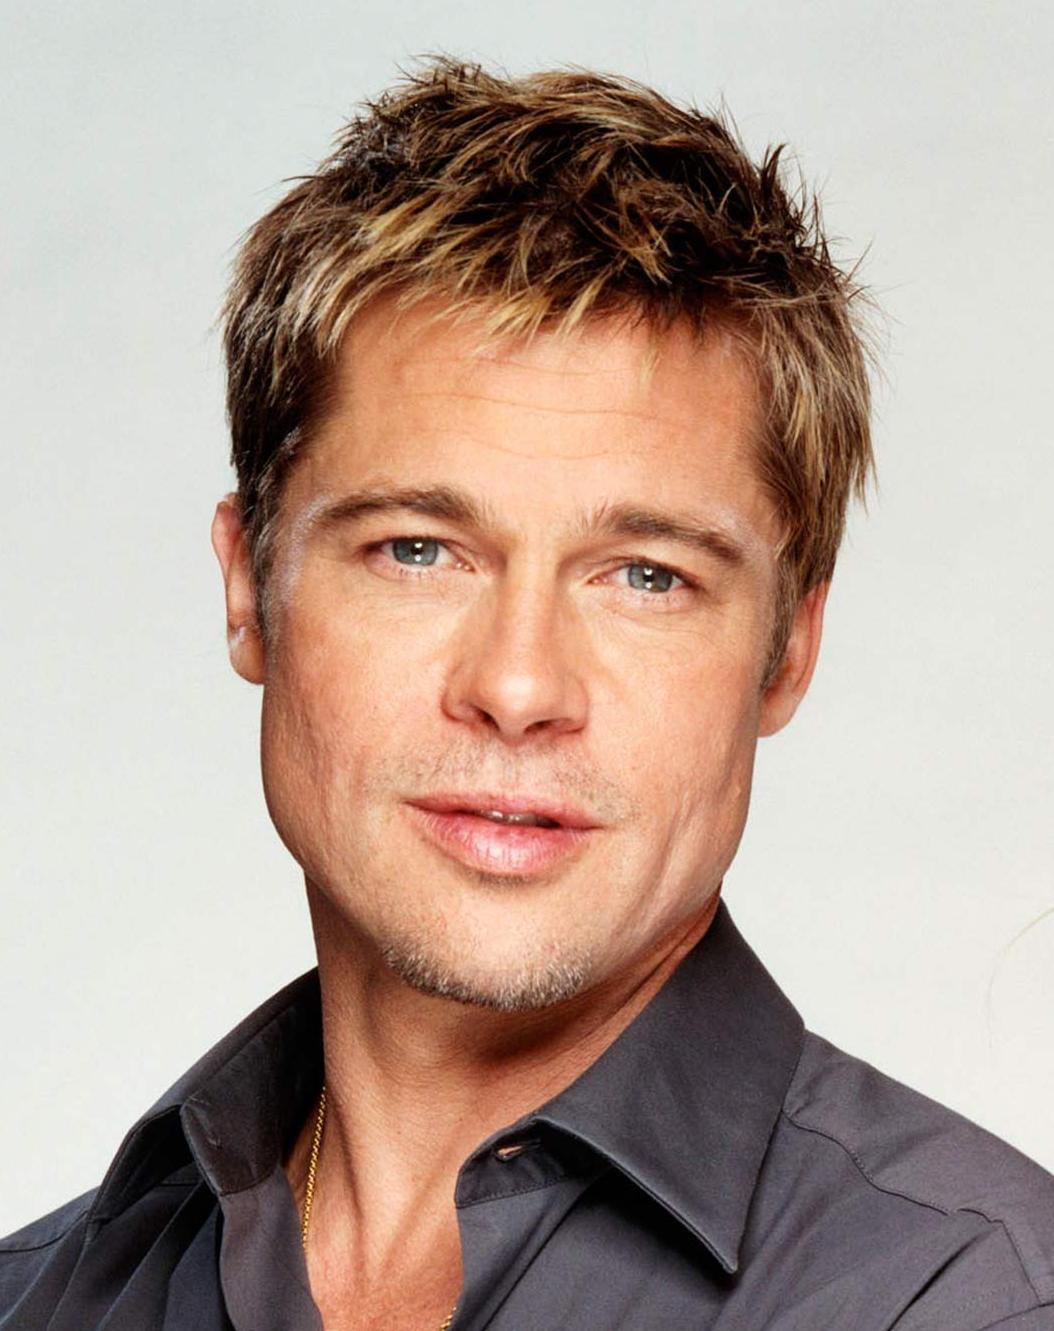

In [21]:
IPython.display.Image(filename = "./brad_pitt.jpg")

And actually load these images:

In [22]:
style   = caffe.io.load_image("./escher_sphere.jpg")
content = caffe.io.load_image("./brad_pitt.jpg")

## Preprocessing
We need to condition our input images to be in the same format and range as the images on which the neural network was trained. Luckily, most of these networks were trained on [ImageNet](http://www.image-net.org/) data and this information is available via <https://github.com/BVLC/caffe/blob/master/python/caffe/imagenet/ilsvrc_2012_mean.npy>. We can load this and produce a caffe.io.Transformer from it, and we must use this throughout anytime we have image data coming in or out of the neural network.

In [23]:
mean_data = numpy.load("caffenet/ilsvrc_2012_mean.npy")
xform = caffe.io.Transformer({"data": net.blobs["data"].data.shape})
xform.set_mean("data", mean_data.mean(1).mean(1))
xform.set_channel_swap("data", (2,1,0))
xform.set_transpose("data", (2,0,1))
xform.set_raw_scale("data", 255)

We also need to scale the images to a certain size, and in some cases scale the style image up a little.  The below does this, using `skimage.transform.rescale` to scale each image's longest edge to `size`.

In [24]:
size = 512
style_scale = 1.2
content_scaled = skimage.transform.rescale(
    content, float(size) / max(content.shape[:2]))
style_scaled = skimage.transform.rescale(
    style, style_scale * float(size) / max(style.shape[:2]))

`size` can be made much larger for higher-resolution results, just be aware that it will raise computation time sharply.

## Feature Responses in Neural Network
Finally, at this point we can get into the actual method of the paper (around page 9 now). Below we are computing the *feature responses* of the content image on the layers of the neural network that we selected as content layers. The first couple lines are just adapting the neural network's shape to this particular image size:

In [27]:
ch, w, h = content_scaled.shape[2], content_scaled.shape[0], content_scaled.shape[1]
net.blobs["data"].reshape(1, ch, w, h)
xform.inputs["data"] = (1, ch, w, h)

Then we are actually running a forward pass of the neural network using this (conditioned) input, and getting the activations of the layer:

In [28]:
net.blobs["data"].data[0] = xform.preprocess("data", content_scaled)
net.forward()
content_repr = {}
for layer in content_layers:
    act = net.blobs[layer].data[0].copy()
    act.shape = (act.shape[0], -1)
    content_repr[layer] = act

We then run nearly the same thing on the style image. Where it differs with the style image is that here we're building a feature correlation, for which we use the Gram matrix (see page 10 of the paper).  `numpy.dot(act, act.T)` is one easy way to compute this; `sgemm` from [BLAS](http://www.math.utah.edu/software/lapack/lapack-blas/sgemm.html) is another.

In [29]:
dims, x, y = style_scaled.shape[2], style_scaled.shape[0], style_scaled.shape[1]
net.blobs["data"].reshape(1, dims, x, y)
xform.inputs["data"] = (1, dims, x, y)
net.blobs["data"].data[0] = xform.preprocess("data", style_scaled)
net.forward()
style_repr = {}
for layer in style_layers:
    act = net.blobs[layer].data[0].copy()
    act.shape = (act.shape[0], -1)
    style_repr[layer] = numpy.dot(act, act.T)

`content_repr` and `style_repr` then are dictionaries whose keys are the layer name, and whose values are the image representation at that layer (of the content features of our content image, and style features of our style image, respectively.)

Now, all we need to do is find an image that, when run through this same neural network, produces approximately the same content representation and the same style representation as what we just computed, and looks okay - for whatever vague definition of "approximately" and "looks okay" we choose to apply. That's simple enough, right? It's just a minimization problem with roughly this many dimensions:

In [32]:
content_scaled.size

622080

## Generating a New Image